# Plotting Relative and Absolute Free Energy Predictions with ``cinnabar``

``cinnabar`` provides high-level plotting functions (powered by Matplotlib or Plotly) for analyzing and comparing relative and absolute binding free energy calculations. All analysis and visualization defaults follow standardized best practices from the [community guidelines](https://doi.org/10.33011/livecoms.4.1.1497)
, ensuring your results are robust, reproducible, and interpretable.

This tutorial demonstrates the ``cinnabar`` API, starting from an ``FEMap`` object, and shows how to generate best-practices plots that are fully customizable. 

## Creating the ``FEMap``

The ``FEMap`` object is the central datastructure in ``cinnabar``. It represents free energy information as a graph:

- **Nodes** are ligands.
- **Edges** are relative free energy differences (ΔΔG) between ligands.
- **Absolute values** (experimental or inferred) can be attached to nodes.

This graph representation is powerful: it allows integration of relative and absolute data, and it provides the foundation for robust statistical analysis and visualization.

In this example, we will analyze a set of relative binding free energies computed with [OpenFE](https://docs.openfree.energy/en/latest/), and compare them with experimental affinities, a common task in the benchmarking and validation of a free energy pipeline. 


In [1]:
from cinnabar.femap import FEMap
%matplotlib inline
from cinnabar import plotting # load the matplotlib plotting functionality
from openff.units import unit
import numpy as np


# load the results of some relative free energy calculations and the associated experimental data from cinnabar tests
rbfe_results = {}
experimental_results = {}
with open("../cinnabar/data/example.csv", "r") as f:
    lines = f.readlines()
    for line in lines[2:38]:
        ligand, dg, uncertainty = line.split(",")
        experimental_results[ligand] = (float(dg), float(uncertainty))

    for line in lines[41:]:
        ligand_a, ligand_b, ddg, uncertainty, _ = line.split(",")
        rbfe_results[(ligand_a.strip(), ligand_b.strip())] = {
            "calculated": float(ddg),
            "uncertainty": float(uncertainty)
        }

We can now create an empty ``FEMap`` object and add the calculated relative free energies:

In [2]:
femap = FEMap()
for (ligand_a, ligand_b), result in rbfe_results.items():
    femap.add_relative_calculation(
        labelA=ligand_a,
        labelB=ligand_b,
        value=result["calculated"] * unit.kilocalorie_per_mole,
        uncertainty=result["uncertainty"] * unit.kilocalorie_per_mole,
        source="OpenFE"
    )


Next, we add the experimental measurements:

In [3]:
for ligand, (dg, uncertainty) in experimental_results.items():
    femap.add_experimental_measurement(
        label=ligand,
        value=dg * unit.kilocalorie_per_mole,
        uncertainty=uncertainty * unit.kilocalorie_per_mole,
        source="Experimental"
    )

<div class="alert alert-block alert-info"> 
<b>NOTE</b> Be consistent with ligand names when adding experimental and calculated data, as this is how results are matched during plotting and statistical analysis.
</div>

## Plotting Relative Free Energies (ΔΔG)

Relative free energy plots allow direct comparison of calculated and experimental ΔΔG values. These plots follow best practices:

- **Only error statistics (RMSE, MUE)** are shown by default. Correlation measures (R², ρ) are not meaningful here, because the direction of a relative transformation is arbitrary.
- **Uncertainty estimates** are bootstrapped (1000 samples with replacement) to provide 95% confidence intervals.

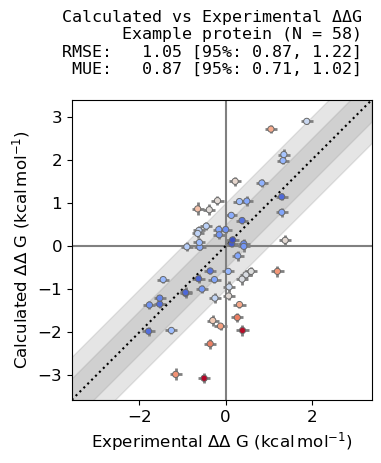

In [4]:
plotting.plot_DDGs(
    femap.to_legacy_graph(), 
    target_name="Example protein", 
    title="Calculated vs Experimental ΔΔG", 
    figsize=5
)

### Symmetry in relative data

Relative transformations are symmetric: ΔΔG(A→B) = –ΔΔG(B→A). This arbitrariness motivates different visualization strategies, without changing the statistics:

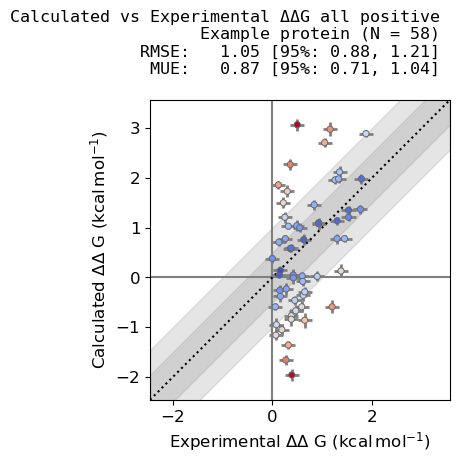

In [5]:
plotting.plot_DDGs(
    femap.to_legacy_graph(), 
    target_name="Example protein", 
    title="Calculated vs Experimental ΔΔG all positive", 
    figsize=5,
    map_positive=True, # Map all relative free energies to have a positive experimental value
)

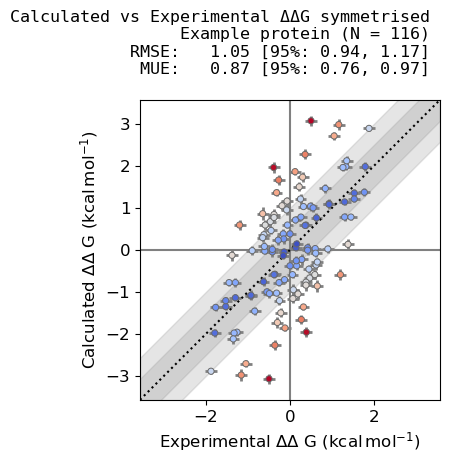

In [6]:
plotting.plot_DDGs(
    femap.to_legacy_graph(), 
    target_name="Example protein", 
    title="Calculated vs Experimental ΔΔG symmetrised", 
    figsize=5,
    symmetrise=True, # Symmetrise the plot by plotting each point twice
)

### Customizing plots

By default, RMSE and MUE are reported. You can add additional metrics (e.g. relative absolute error, RAE) and choose whether to report the **sample value** (``mle``) or the **bootstrap mean** (``mean``):

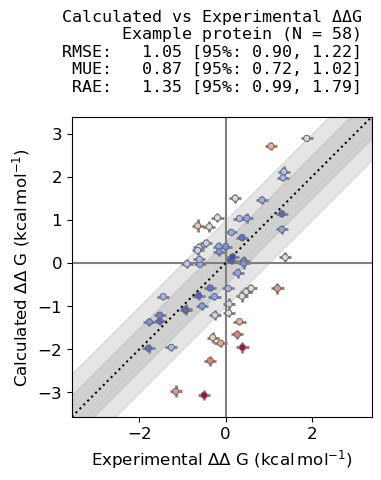

In [7]:
plotting.plot_DDGs(
    femap.to_legacy_graph(), 
    target_name="Example protein", 
    title="Calculated vs Experimental ΔΔG", 
    figsize=5, 
    statistics=["RMSE", "MUE", "RAE"], # add RAE to the plot,
    statistic_type="mean", # change the reported value from the sample value to the mean of the bootstrapped samples
    )

Plots include shaded guidelines (0.5 and 1 kcal/mol) and color points by absolute error. Both are customizable:

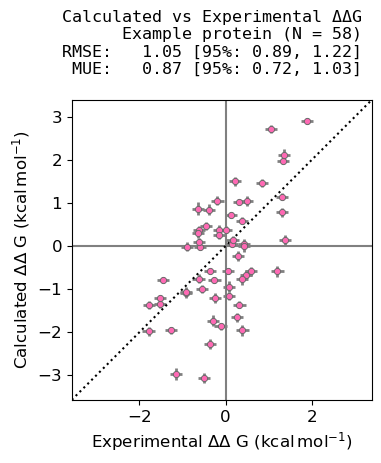

In [8]:
# turn off the guidelines
plotting.plot_DDGs(
    femap.to_legacy_graph(), 
    target_name="Example protein", 
    title="Calculated vs Experimental ΔΔG", 
    figsize=5, 
    guidelines=False, # Turn off the guidelines
    color="hotpink" # use a custom color
)

For full control, pass Matplotlib settings via scatter_kwargs:

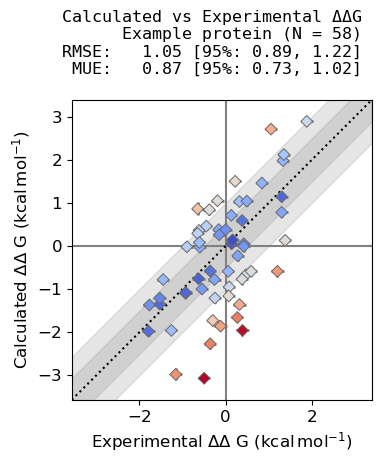

In [9]:
plotting.plot_DDGs(
    femap.to_legacy_graph(), 
    target_name="Example protein", 
    title="Calculated vs Experimental ΔΔG", 
    figsize=5, 
    scatter_kwargs={"marker": "D"},
)

If no filename is provided, the plotting function returns a Matplotlib ``Figure`` for further customization.

## Plotting Absolute Free Energies (ΔG)

Absolute free energies can be estimated from a sufficiently connected relative free energy network. Internally, ``cinnabar`` applies a **maximum likelihood estimator (MLE)** to reconstruct the set of ΔG values most consistent with the relative data. This is performed automatically in plotting functions, or explicitly via ``FEMap.generate_absolute_values()``.

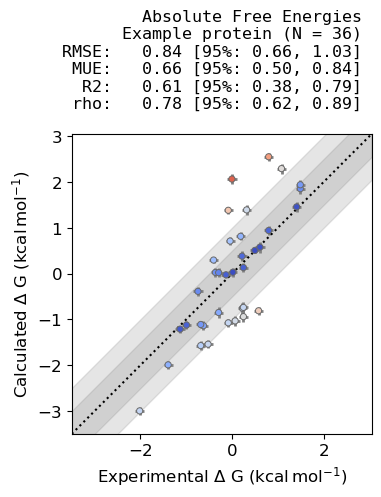

In [10]:
plotting.plot_DGs(
    femap.to_legacy_graph(),
    figsize=5,
    target_name="Example protein",
    title="Absolute Free Energies",
)

Here, both **error and correlation statistics (RMSE, MUE, R², ρ)** are reported, since absolute data are directional and correlation is meaningful.

<div class="alert alert-block alert-warning"> <b>Important:</b> The absolute scale of ΔG values is arbitrary. The MLE reconstruction centers values around zero, so they do not correspond to experimentaly measured absolute binding affinities. Comparisons are valid <i>within a ligand series</i>, but the zero point carries no physical meaning. </div>



### Applying an Experimental Shift

When comparing absolute free energies from different methods, it is sometimes useful to apply a constant shift so that the predicted values align with the experimental mean.

This does not change the relative ranking of ligands or the spread of errors — it only removes the arbitrary offset that arises from the MLE reconstruction of absolute ΔGs. This way, plots are visually centered on the experimental trend, which can help with presentation and comparison.

<div class="alert alert-block alert-warning"> <b>Important:</b> This should be done only for visualization or communication. </div>

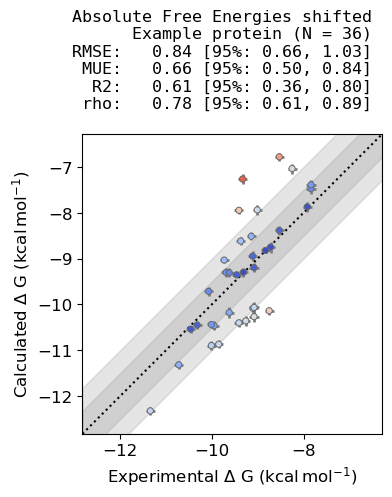

In [11]:
plotting.plot_DGs(
    femap.to_legacy_graph(),
    target_name="Example protein",
    title="Absolute Free Energies shifted",
    figsize=5,
    shift=np.mean([exp[0] for exp in experimental_results.values()])
)

## Plotting All ΔΔGs (from reconstructed ΔGs)

By default, relative plots show only the ΔΔGs that were **directly simulated** (i.e., edges in your transformation graph). However, once absolute free energies (ΔGs) are reconstructed with the MLE, you can compute **all pairwise ΔΔGs** between ligands.

This has two advantages:

- **Network-independent comparisons**: Different methods may have used different transformation graphs. By reconstructing all ΔΔGs from absolute values, you can compare methods on a common set of relative predictions.
- **Complete benchmarking**: This approach makes it easy to see systematic trends across the full ligand set, not just those pairs chosen for RBFE calculations.

For example, you can generate a plot of all ΔΔGs like this:

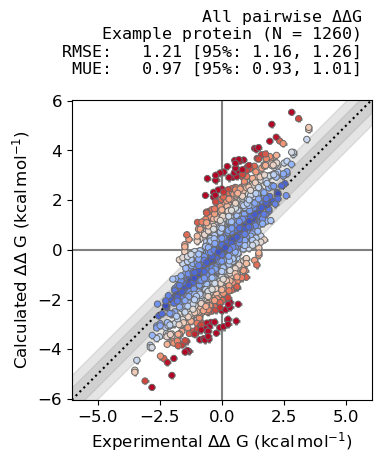

In [12]:
plotting.plot_all_DDGs(
    femap.to_legacy_graph(),
    figsize=5,
    target_name="Example protein",
    title="All pairwise ΔΔG"
)

Again, the same best-practices defaults apply (error statistics only, bootstrapped confidence intervals).